In [1]:
import numpy as np
import seaborn as sns
import torch
import matplotlib.pyplot as plt
import argparse
import pickle
import pandas as pd

from utils import *
from data_builder import *
from utils import *
from model_builder import get_models


%matplotlib inline


/Users/shaan/anaconda3/envs/main/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:

parser = argparse.ArgumentParser()
parser.add_argument("-n_test_traj", '--ntesttraj', type=int, default=25)
parser.add_argument('-dt', '--dt', type=float, default=0.1)
parser.add_argument('-tmax', '--tmax', type=float, default=30.1)
parser.add_argument('-dname', '--dname', type=str, default='damped')
parser.add_argument('-noise_std', '--noise', type=float, default=0)
parser.add_argument('-type','--type',type=int,default=1)
args = parser.parse_args([])
n_test_traj = args.ntesttraj
T_max = args.tmax
T_max_t = args.tmax
dt = args.dt
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
type_vec = args.type
num_samples_per_traj = int(np.ceil((T_max_t / dt))) - 1

if args.noise != 0:
    noisy = True
else:
    noisy = False

dataset_name = args.dname

# dataset preprocessing
valid_data = get_dataset(dataset_name, n_test_traj, T_max_t, dt, noise_std=0, seed=10,type=type_vec)
BS = num_samples_per_traj

vnow, vnext, venergy, vdx, vevals = nownext(valid_data, n_test_traj, T_max_t, dt, dt)


valdat = pendpixdata(vnow, vnext, venergy, vdx, vevals)
val_dataloader = DataLoader(valdat, batch_size=BS, num_workers=2, shuffle=False)

data_dict = { 'valid': val_dataloader}
running_losses = 0.
loss_collater = { 'valid': []}


def integrate_model(model, t_span, y0,t_eval, **kwargs):
    
    def fun(t, np_x):
        x = torch.tensor( np_x, requires_grad=True, dtype=torch.float32).view(1,2)
        t = torch.tensor( t, requires_grad=True, dtype=torch.float32).view(1,1) 
        dx = model.time_deriv(x,t).data.numpy().reshape(-1)
        return dx

    return solve_ivp(fun=fun, t_span=t_span, y0=y0,t_eval=t_eval, **kwargs)

def test_model(model_name,model):
    # Each epoch has a training and validation phase
    for phase in ['valid']:
        for batch_i, (q, q_next, _, qdx, tevals) in enumerate(data_dict[phase]):
            q, q_next, qdx = q.float(), q_next.float(), qdx.float()
            q.to(device)
            q_next.to(device)
            qdx.to(device)
            tevals = tevals.float()
            tevals.to(device)
            loss = 0
            q.requires_grad = True
            tevals.requires_grad = True

            qinit = q[0].reshape(1, -1)

            preds = integrate_model(model,[0,T_max_t],qinit.detach().numpy().ravel(),t_eval=np.arange(0,T_max_t,dt)).y

            main_pred[model_name].append(((preds.T)[:-1],q.detach().numpy()))




In [3]:
main_pred = {'baseline':[],'HNN':[],'TDHNN':[],'TDHNN4':[]}
model_nms = list(main_pred.keys())
for model_name in model_nms:
    model_type = torch.load(f'damped_1/{model_name}/model',map_location='cpu')
    model_type.eval()
    test_model(model_name,model_type)
    

/Users/shaan/anaconda3/envs/main/lib/python3.7/site-packages/torch/serialization.py:649: SourceChangeWarning: source code of class 'models.baseline.base_model' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/Users/shaan/anaconda3/envs/main/lib/python3.7/site-packages/torch/serialization.py:649: SourceChangeWarning: source code of class 'torch.nn.modules.linear.Linear' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/Users/shaan/anaconda3/envs/main/lib/python3.7/site-packages/torch/serialization.py:649: SourceChangeWarning: source code of class 'models.TDHNN4.TDHNN4' has changed. you can retrieve the original source code by ac

In [4]:
def hamiltonian_fn(coords,typev=1):
    q, p = coords[:,0],coords[:,1]
    K = (p ** 2) / 2 
    U = (q ** 2) / 2  # spring hamiltonian (linear oscillator)
    t = np.arange(0,T_max_t,dt)[:1]
    K = (p ** 2) / 2 
    U = (q ** 2) / 2  # spring hamiltonian (linear oscillator)
#     return K+U#-q*np.sin(3*t)
    if typev == 1:
        return K,U
    else:
        return K+U#-q*sin(3*t)

In [5]:
avg_perf = {}

new_df = pd.DataFrame(columns=['Method','State Error','Energy Error'])

for model in model_nms:
    vals = main_pred[model]
    for i in range(len(vals)):
        pred = vals[i][0]
        true = vals[i][1]
        state_error = np.mean(np.square(pred-true))
        energy_error = np.mean(np.square(hamiltonian_fn(pred,2)-hamiltonian_fn(true,2)))
        new_df.loc[len(new_df)] = [model,state_error,energy_error]

In [6]:
new_df.groupby('Method')['State Error'].mean(),new_df.groupby('Method')['Energy Error'].mean()

(Method
 HNN         0.262100
 TDHNN       0.292980
 TDHNN4      0.000006
 baseline    0.000014
 Name: State Error, dtype: float64, Method
 HNN         1.571302e-01
 TDHNN       1.741888e-01
 TDHNN4      3.578058e-07
 baseline    7.760964e-07
 Name: Energy Error, dtype: float64)

In [6]:
sns.axes_style(style='ticks')
sns.set_context("paper",font_scale=1.4, rc={'figure.figsize':(5,5),"font.size":20,"axes.titlesize":20,"axes.labelsize":20,'lines.linewidth':3})
sns.set_palette('deep')

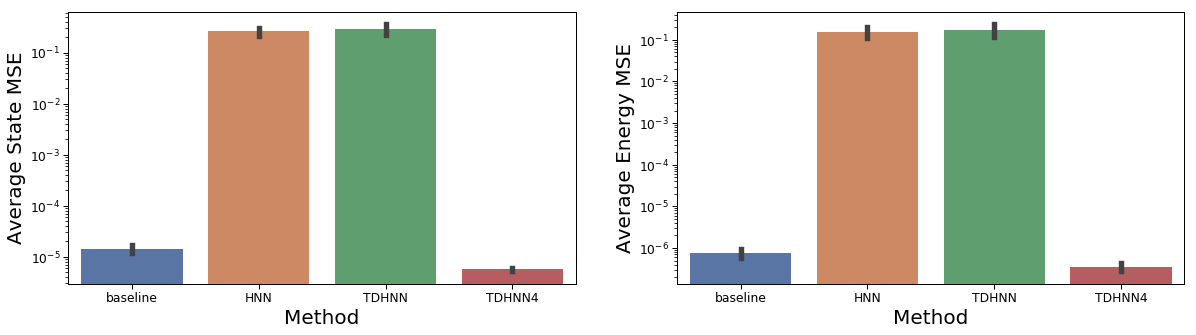

In [39]:
fig,ax = plt.subplots(1,2,figsize=(20,5))
# sns.set_context("poster")
g = sns.barplot(x='Method',y='State Error',data=new_df,ax=ax[0])
g.set_yscale('log')

g = sns.barplot(x='Method',y='Energy Error',data=new_df,ax=ax[1])
g.set_yscale('log')

ax[1].set_ylabel('Average Energy MSE')
ax[0].set_ylabel('Average State MSE')

plt.savefig('damped_1_errors.pdf',format='pdf',dpi=2400,bbox_inches='tight')


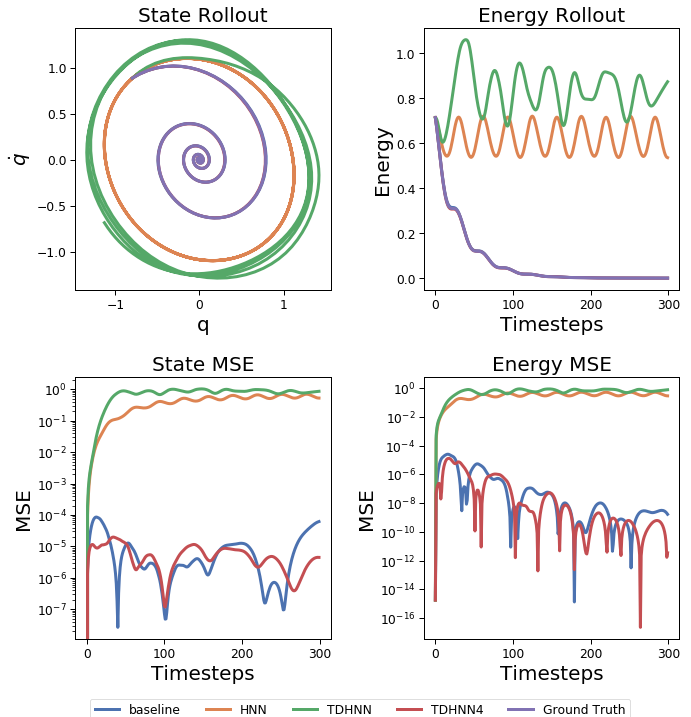

In [9]:
sns.axes_style(style='ticks')
sns.set_context("paper",font_scale=1.4, rc={'figure.figsize':(5,5),"font.size":20,"axes.titlesize":20,"axes.labelsize":20,'lines.linewidth':3})

lab_list = list(model_nms)[:]
fig,axs = plt.subplots(2,2,figsize=(10,10))
ax = axs.ravel()
#ax = axs.ravel()
# lab_list.remove('TDHNN')
# lab_list.remove('TDHNN1')
for dex,name in enumerate(lab_list):
    yhat = main_pred[name][-4][0]
    true_batch = main_pred[name][-4][1]
                    
    K_pred,U_pred = hamiltonian_fn(yhat,1)
    K_true,U_true = hamiltonian_fn(true_batch,1)
    ham_pred = K_pred + U_pred
    ham_true = K_true + U_true
    
    ax[0].set_title('State Rollout')
    sns.lineplot(x=yhat[::,0],y=yhat[::,1],label=lab_list[dex],sort=False,ax=ax[0],legend=False)
#     sns.lineplot(x=range(len(yhat[::,0])),y=yhat[::,1],label=lab_list[dex],sort=False,ax=ax[0],legend=False)
    
    ax[0].set_xlabel('q')
    ax[0].set_ylabel(r'$\dot{q}$')


    ax[1].set_title('Energy Rollout')
    sns.lineplot(x=range(len(ham_pred)),y=ham_pred,label=lab_list[dex],ax=ax[1],legend=False)
    ax[1].set_xlabel('Timesteps')
    ax[1].set_ylabel('Energy')



    ax[2].set_title('State MSE')
    l1 =sns.lineplot(x=range(len(yhat)),y=((yhat-true_batch)**2).mean(1),label=lab_list[dex],ax=ax[2],legend=False)
    ax[2].set_xlabel('Timesteps')
    ax[2].set_ylabel('MSE')

    ax[3].set_title('Energy MSE')
    l2 =sns.lineplot(x=range(len(yhat)),y=(ham_pred-ham_true)**2,label=lab_list[dex],ax=ax[3],legend=False)
    ax[3].set_xlabel('Timesteps')
    ax[3].set_ylabel('MSE')
    
sns.lineplot(x=true_batch[:,0],y=true_batch[:,1],markers='x',label='Ground Truth',ax=ax[0],sort=False,legend=False)
sns.lineplot(x=range(len(ham_pred)),y=ham_true,label='Ground Truth',ax=ax[1],legend=False)
sns.lineplot(x=range(len(yhat)),y=np.zeros(len(yhat)),label='Ground Truth',ax=ax[2],legend=False)
sns.lineplot(x=range(len(yhat)),y=np.zeros(len(yhat)),label='Ground Truth',ax=ax[3],legend=False)
ax[1].ticklabel_format(axis="y", style="sci", scilimits=(0,0))
ax[2].ticklabel_format(axis="y", style="sci", scilimits=(0,0))
ax[3].ticklabel_format(axis="y", style="sci", scilimits=(0,0))
# ax[1].set_yscale('log')
ax[2].set_yscale('log')
ax[3].set_yscale('log')

handles, labels = ax[3].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center',bbox_to_anchor=(0.5, -0.015),fancybox=True,ncol=6)
plt.tight_layout()
plt.savefig('damped_1_pred.pdf',dpi=2400,bbox_inches='tight')


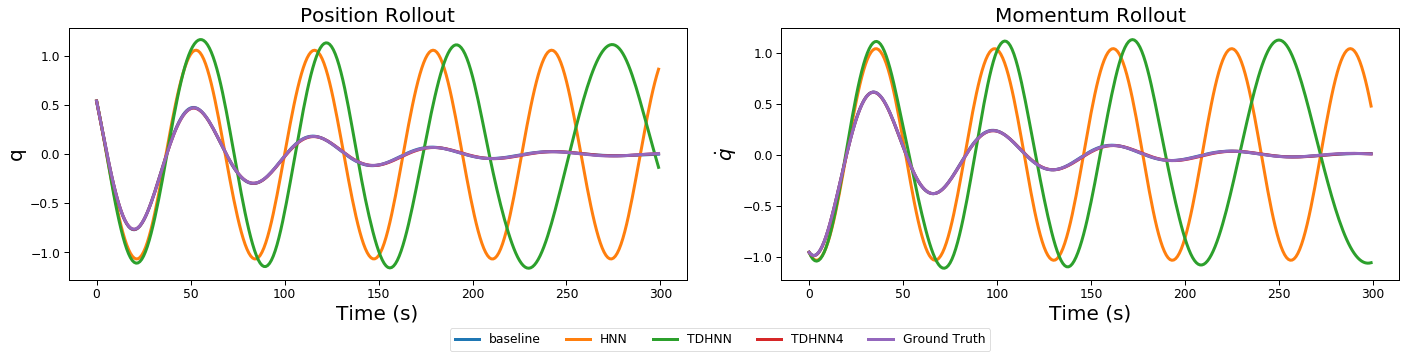

In [14]:
sns.axes_style(style='ticks')
sns.set_context("paper",font_scale=1.4, rc={'figure.figsize':(5,5),"font.size":20,"axes.titlesize":20,"axes.labelsize":20,'lines.linewidth':3})

lab_list = model_nms
fig,axs = plt.subplots(1,2,figsize=(5*4,5))
ax = axs.ravel()
#ax = axs.ravel()
# lab_list.remove('HNN')
# lab_list.remove('TDHNN')
# lab_list.remove('TDHNN1')
for dex,name in enumerate(lab_list):
    yhat = main_pred[name][0][0]
    true_batch = main_pred[name][0][1]
                    
    ax[0].set_title('Position Rollout')
    sns.lineplot(x=range(len(yhat)),y=yhat[::,0],label=lab_list[dex],sort=False,ax=ax[0],legend=False)
    ax[0].set_xlabel('Time (s)')
    ax[0].set_ylabel('q')
    
    ax[1].set_title('Momentum Rollout')
    sns.lineplot(x=range(len(yhat)),y=yhat[::,1],label=lab_list[dex],sort=False,ax=ax[1],legend=False)
    ax[1].set_xlabel('Time (s)')
    ax[1].set_ylabel(r'$\dot{q}$')

sns.lineplot(x=range(len(yhat)),y=true_batch[:,0],markers='x',label='Ground Truth',ax=ax[0],sort=False,legend=False)
sns.lineplot(x=range(len(yhat)),y=true_batch[:,1],markers='x',label='Ground Truth',ax=ax[1],sort=False,legend=False)
handles, labels = ax[1].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center',bbox_to_anchor=(0.5, -0.015),fancybox=True,ncol=6)
plt.tight_layout()


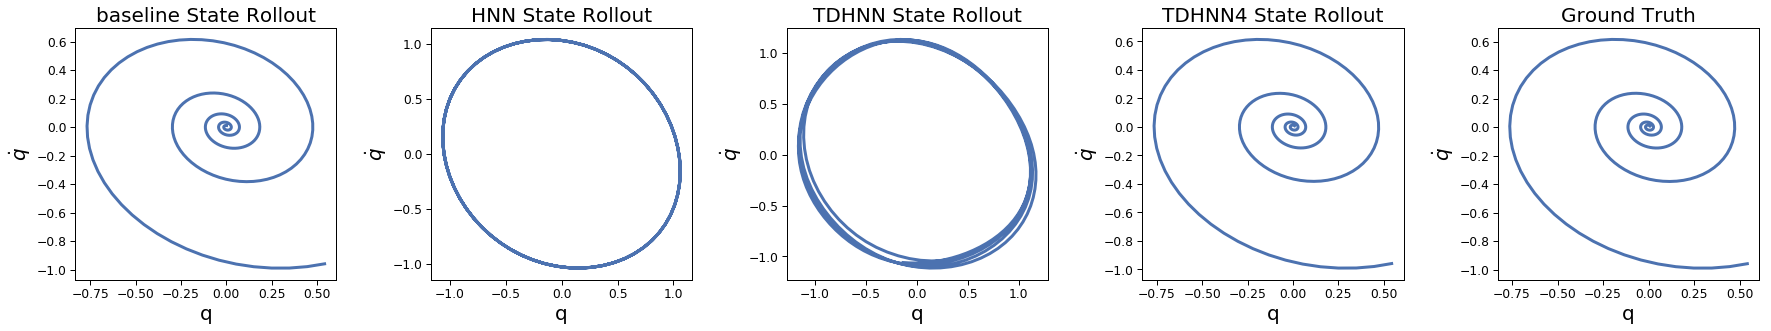

In [23]:
sns.axes_style(style='ticks')
sns.set_context("paper",font_scale=1.4, rc={'figure.figsize':(5,5),"font.size":20,"axes.titlesize":20,"axes.labelsize":20,'lines.linewidth':3})

lab_list = model_nms
fig,axs = plt.subplots(1,len(lab_list)+1,figsize=(5*len(lab_list)+5,5))
ax = axs.ravel()
#ax = axs.ravel()
# lab_list.remove('HNN')
# lab_list.remove('TDHNN')
# lab_list.remove('TDHNN1')
for dex,name in enumerate(lab_list):
    yhat = main_pred[name][0][0]
    true_batch = main_pred[name][0][1]
                    
    ax[dex].set_title(f'{name} State Rollout')
    sns.lineplot(x=yhat[::,0],y=yhat[::,1],label=lab_list[dex],sort=False,ax=ax[dex],legend=False)
    ax[dex].set_xlabel('q')
    ax[dex].set_ylabel(r'$\dot{q}$')
    
    

sns.lineplot(x=true_batch[:,0],y=true_batch[:,1],markers='x',label='Ground Truth',ax=ax[-1],sort=False,legend=False)
ax[-1].set_title('Ground Truth')
ax[-1].set_xlabel('q')
ax[-1].set_ylabel(r'$\dot{q}$')
    
    
# sns.lineplot(x=range(len(yhat)),y=true_batch[:,1],markers='x',label='Ground Truth',ax=ax[dex],sort=False,legend=False)
handles, labels = ax[1].get_legend_handles_labels()
# fig.legend(handles, labels, loc='lower center',bbox_to_anchor=(0.5, -0.015),fancybox=True,ncol=6)
plt.tight_layout()
plt.savefig('damped_rollout.pdf',dpi=2400,bbox_inches='tight')

In [11]:
model_type.mlp1.in_features

2

In [24]:
# train_data = get_dataset(dataset_name, n_test_traj, T_max, dt, noise_std=0, seed=0)
# tnow, tnext, tenergy, tdx, tevals = nownext(train_data, n_test_traj, T_max, dt, dt)

q = torch.arange(-2,2,0.01)
qd = torch.arange(-2,2,0.01)
q= q.float()
qd = qd.float()
q.requires_grad = True
qd.requires_grad = True
# qvec = torch.cat([q.reshape(-1,1),qd.reshape(-1,1)],1)
# f = model_type.get_H(qvec)
qm,qdm = torch.meshgrid(q,qd)



torch.Size([160000, 1])


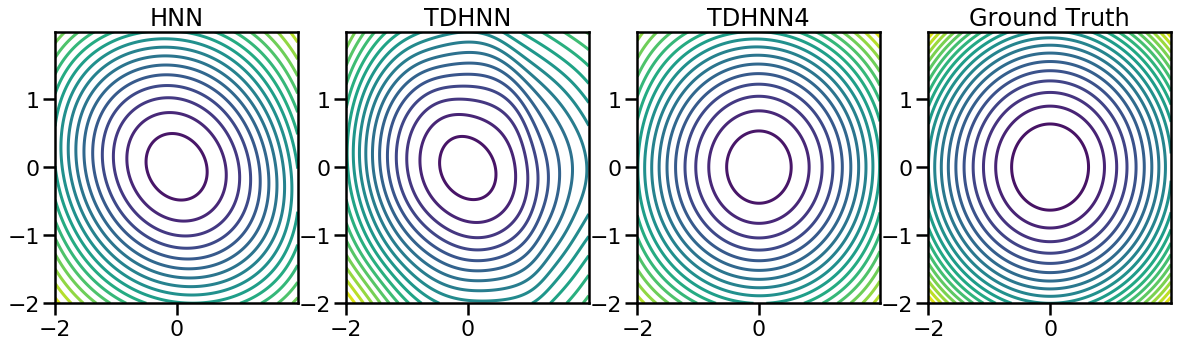

In [36]:
new_model_nms = model_nms[1:]#list(set(model_nms)-set('baseline'))
fig,axs = plt.subplots(1,len(model_nms),figsize=(5*len(model_nms),5))
ax = axs.ravel()
for i,model_name in enumerate(new_model_nms):
    model_type = torch.load(f'damped_1/{model_name}/model',map_location='cpu')
    model_type.eval()
    if model_type.mlp1.in_features == 3:
        f = model_type.get_H(torch.cat([qm.reshape(-1,1),qdm.reshape(-1,1),torch.zeros(*qm.shape).reshape(-1,1)],1))
        print(f.shape)
    else:
        f = model_type.get_H(torch.cat([qm.reshape(-1,1),qdm.reshape(-1,1)],1))
    ax[i].contour(qm.detach().numpy(),qdm.detach().numpy(),f.reshape(-1,qm.shape[0]).detach().numpy(),levels=20)
    ax[i].set_title(model_name)
    #     ax[i].set_colorbar()
    # plt.scatter(tnow[:,0],tnow[:,1],marker='x',s=0.2)

ftrue = hamiltonian_fn((torch.cat([qm.reshape(-1,1),qdm.reshape(-1,1)],1)).detach().numpy(),2)
ax[-1].contour(qm.detach().numpy(),qdm.detach().numpy(),ftrue.reshape(-1,qm.shape[0]),levels=20)
ax[-1].set_title('Ground Truth')
plt.savefig('damped_contour.pdf',dpi=2400,bbox_inches='tight')

In [ ]:
new_model_nms = model_nms[1:]#list(set(model_nms)-set('baseline'))
fig,axs = plt.subplots(1,len(model_nms)-1,figsize=(5*len(model_nms)-5,5))
ax = axs.ravel()
ftrue = hamiltonian_fn(torch.cat([qm.reshape(-1,1),qdm.reshape(-1,1)],1),2)
for i,model_name in enumerate(new_model_nms):
    model_type = torch.load(f'mass_spring/{model_name}/model',map_location='cpu')
    model_type.eval()
    if model_type.mlp1.in_features == 3:
        f = model_type.get_H(torch.cat([qm.reshape(-1,1),qdm.reshape(-1,1),torch.zeros(*qm.shape).reshape(-1,1)],1))
        print(f.shape)
    else:
        f = model_type.get_H(torch.cat([qm.reshape(-1,1),qdm.reshape(-1,1)],1))
    
    
    
    ax[i].scatter(f.detach().numpy(),ftrue.detach().numpy(),s=0.1,alpha=0.2,marker='x')
    fit = np.polyfit(f.detach().numpy().ravel(),ftrue.detach().numpy().ravel(),1)
    ax[i].plot(f.detach().numpy().ravel(),fit[0]*f.detach().numpy().ravel()+fit[1])
    ax[i].set_title(f'{model_name} fit')


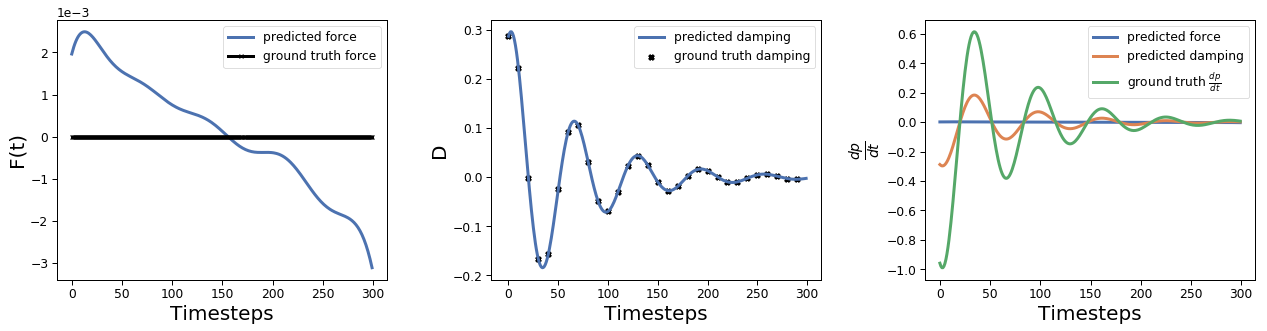

In [32]:
sns.axes_style(style='ticks')
sns.set_context("paper",font_scale=1.4, rc={'figure.figsize':(5,5),"font.size":20,"axes.titlesize":20,"axes.labelsize":20,'lines.linewidth':3})
sns.set_palette('deep')
fig,ax = plt.subplots(1,3,figsize=(18,5))
axs = ax.ravel()
for batch_i, (q, q_next, energy_, qdx, tevals) in enumerate(data_dict['valid']):
    q=q.to(device)
    q=q.float()
    q.requires_grad=True
    tevals.to(device)
    tevals.requires_grad = True
    tevals = tevals.float()
    d = model_type.get_D()
    f = model_type.get_F(tevals.reshape(-1,1))
    axs[0].plot(-(f).detach().numpy(),label='predicted force')
    axs[0].plot(np.zeros(len(f)),label='ground truth force',c='black',marker='x')
#     axs[0].set_title('Predicted Force')
    axs[0].legend(loc='best')
    axs[1].plot((d[0]*q[:,1]).detach().numpy(),label='predicted damping')
    axs[1].scatter(range(len(q))[::10],(d[0]*q[::10,1]).detach().numpy(),label='ground truth damping',c='black',marker='x')
#     axs[1].set_title('Predicted Damping')
    axs[1].legend(loc='best')
    axs[0].ticklabel_format(axis="y", style="sci", scilimits=(0,0))
    
    
    axs[2].plot(-(f).detach().numpy(),label='predicted force')
    axs[2].plot(-(d[0]*q[:,1]).detach().numpy(),label='predicted damping')
    axs[2].plot(q[:,1].detach().numpy(),label=r'ground truth $\frac{dp}{dt}$')
    axs[2].legend(loc='best')
    axs[2].ticklabel_format(axis="y", style="sci", scilimits=(0,0))
    
    
    axs[2].set_xlabel('Timesteps')
    axs[0].set_xlabel('Timesteps')
    axs[1].set_xlabel('Timesteps')
    
    axs[0].set_ylabel(r'F(t)')
    axs[1].set_ylabel(r'D')
    axs[2].set_ylabel(r'$\frac{dp}{dt}$')


    break
plt.tight_layout()
plt.savefig('dpdt_damped.pdf',dpi=2400,bbox_inches='tight')

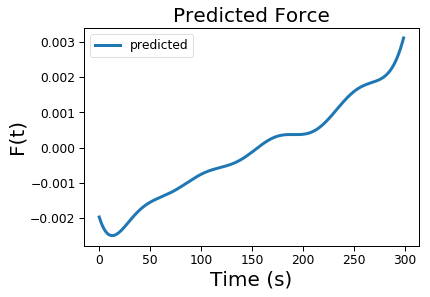

In [18]:
for batch_i, (q, q_next, energy_, qdx, tevals) in enumerate(data_dict['valid']):
    tevals.to(device)
    tevals.requires_grad = True
    tevals = tevals.float()
    f = model_type.get_F(tevals.reshape(-1,1))
    #w = torch.relu(torch.sign(model_type.W))
    plt.plot((f).detach().numpy(),label='predicted')
#     plt.plot(torch.sin(3*tevals).detach().numpy(),label='ground truth')
    plt.title('Predicted Force')
    plt.xlabel('Time (s)')
    plt.ylabel('F(t)')
    plt.legend(loc='best')
    plt.savefig('TDHNN4_damped_1.pdf',dpi=2400,bbox_inches='tight')
    break

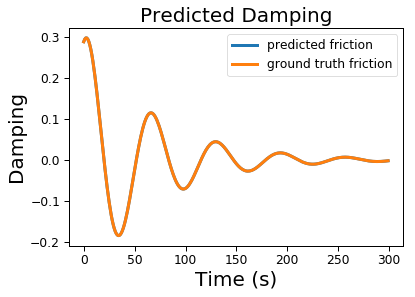

In [23]:
for batch_i, (q, q_next, energy_, qdx, tevals) in enumerate(data_dict['valid']):
    q=q.to(device)
    q=q.float()
    q.requires_grad=True
    tevals.to(device)
    tevals.requires_grad = True
    tevals = tevals.float()
    d = model_type.get_D()
#     w = torch.relu(torch.sign(model_type.Wd))
    plt.plot((d[0]*q[:,1]).detach().numpy(),label='predicted friction')
    plt.plot(-0.3*q[:,1].detach().numpy(),label=r'ground truth friction')
    plt.title('Predicted Damping')
    plt.legend()
    plt.xlabel('Time (s)')
    plt.ylabel('Damping')
    plt.savefig('TDHNN4_damped_1.pdf',dpi=2400,bbox_inches='tight')
    break
    

In [15]:
list(model_type.parameters())[2:]

[Parameter containing:
 tensor([[-0.1049, -0.2016],
         [-0.0673, -0.1077],
         [-0.0496, -0.0999],
         [-0.0743,  0.0055],
         [-0.0646, -0.0604],
         [ 0.0071, -0.1432],
         [-0.0125, -0.1463],
         [ 0.0305, -0.1038],
         [ 0.0012,  0.0277],
         [-0.0574,  0.0195],
         [-0.0072,  0.2038],
         [-0.0970,  0.0852],
         [ 0.0302, -0.0272],
         [ 0.0792, -0.0206],
         [-0.1118, -0.0952],
         [-0.0582,  0.2074],
         [-0.0078,  0.0353],
         [ 0.1054, -0.1208],
         [-0.1313,  0.0726],
         [ 0.0066,  0.1177],
         [-0.0184,  0.0589],
         [ 0.0475,  0.0905],
         [ 0.1239,  0.0597],
         [ 0.0593, -0.0802],
         [-0.0041, -0.1183],
         [ 0.1042,  0.1044],
         [ 0.1025,  0.0482],
         [-0.0405,  0.0517],
         [ 0.0120,  0.2086],
         [-0.0160, -0.1143],
         [-0.0786,  0.0689],
         [-0.1247,  0.0955],
         [ 0.0852, -0.1308],
         [-0.0835, -